# 0 Imports and helper functions

In [0]:
import sklearn
import pandas as pd
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import roc_curve, auc
import json

%matplotlib inline

# 1 Loading the data

In this notebook we build a decision tree binary classifier to predict wether or not a flight will be delayed. It is based on the same dataset as in notebook 4, where we built a binary classifier with logistic regression. All data preprocessing steps are the same, and we will simply directly import the processed dataset containing the joined flight, delay and weather information.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
delays = pd.read_csv("/content/drive/My Drive/xylosai/flightDelay/FlightDelaysData_clean.csv",header=0,index_col = 0)
delays.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,OriginAirportID,DestAirportID,ArrDel15,Carrier_0,Carrier_1,Carrier_2,Carrier_3,Carrier_4,Carrier_5,Carrier_6,...,DestAirportID_54,DestAirportID_55,DestAirportID_56,DestAirportID_57,DestAirportID_58,DestAirportID_59,DestAirportID_60,DestAirportID_61,DestAirportID_62,DestAirportID_63
0,11433,13303,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14869,12478,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14057,14869,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15016,11433,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,10397,15016,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
delays.info(memory_usage='deep',max_cols=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138043 entries, 0 to 2719417
Columns: 181 entries, OriginAirportID to DestAirportID_63
dtypes: float64(12), int64(169)
memory usage: 2.9 GB


In [5]:
# just quickly downcasting all int64 columns (memory)
int_columns = delays.dtypes[delays.dtypes == 'int64'].index.tolist()
counter = 0
for columnname in int_columns:
  counter += 1
  if (counter%5 == 0):
    print("downcasting column {0} of {1}".format(counter,len(int_columns)))
  delays[columnname] = pd.to_numeric(delays[columnname],downcast="integer")
  

downcasting column 5 of 169
downcasting column 10 of 169
downcasting column 15 of 169
downcasting column 20 of 169
downcasting column 25 of 169
downcasting column 30 of 169
downcasting column 35 of 169
downcasting column 40 of 169
downcasting column 45 of 169
downcasting column 50 of 169
downcasting column 55 of 169
downcasting column 60 of 169
downcasting column 65 of 169
downcasting column 70 of 169
downcasting column 75 of 169
downcasting column 80 of 169
downcasting column 85 of 169
downcasting column 90 of 169
downcasting column 95 of 169
downcasting column 100 of 169
downcasting column 105 of 169
downcasting column 110 of 169
downcasting column 115 of 169
downcasting column 120 of 169
downcasting column 125 of 169
downcasting column 130 of 169
downcasting column 135 of 169
downcasting column 140 of 169
downcasting column 145 of 169
downcasting column 150 of 169
downcasting column 155 of 169
downcasting column 160 of 169
downcasting column 165 of 169


In [6]:
delays.info(memory_usage='deep',max_cols=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138043 entries, 0 to 2719417
Columns: 181 entries, OriginAirportID to DestAirportID_63
dtypes: float64(12), int16(2), int8(167)
memory usage: 560.7 MB


# 2 Decision tree classifier

## 2.1 Building a first model

With a decision tree classifier, we can learn non-linear decision boundaries.
We keep the wind direction input. As a reminder, let's look at our final dataset.

In [7]:
delays.columns

Index(['OriginAirportID', 'DestAirportID', 'ArrDel15', 'Carrier_0',
       'Carrier_1', 'Carrier_2', 'Carrier_3', 'Carrier_4', 'Carrier_5',
       'Carrier_6',
       ...
       'DestAirportID_54', 'DestAirportID_55', 'DestAirportID_56',
       'DestAirportID_57', 'DestAirportID_58', 'DestAirportID_59',
       'DestAirportID_60', 'DestAirportID_61', 'DestAirportID_62',
       'DestAirportID_63'],
      dtype='object', length=181)

In [0]:
Y = delays["ArrDel15"]
del delays["ArrDel15"]
X = delays



In [0]:
X_traindev, X_test, Y_traindev, Y_test = train_test_split(X,Y,random_state=0,test_size = 0.10)

del X
del Y


In [0]:
# balancing the classes in the train/dev set, memory-optimized

l_1 = np.sum(Y_traindev == 1)


X_traindev = pd.concat([X_traindev[Y_traindev == 1], X_traindev[Y_traindev == 0][0:l_1]],axis=0)
Y_traindev = pd.concat([Y_traindev[Y_traindev == 1], Y_traindev[Y_traindev == 0][0:l_1]],axis=0)

X_traindev, Y_traindev = sklearn.utils.shuffle(X_traindev, Y_traindev, random_state=0)



In [11]:
# category count in the train/dev set after balancing. Should be equal.
print("not delayed: {0}".format(np.sum(Y_traindev == 0)))
print("delayed: {0}".format(np.sum(Y_traindev == 1)))


not delayed: 408435
delayed: 408435


In [0]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X_traindev,Y_traindev,random_state=0,test_size = 0.10)

del X_traindev
del Y_traindev

In [0]:
clf = tree.DecisionTreeClassifier(random_state=0)

In [14]:
start = time.time()
clf.fit(X_train, Y_train)
end = time.time()

seconds = end-start
print("Fitting took {0} seconds".format(seconds))

Fitting took 73.25384902954102 seconds


## 2.2 Evaluating our model

Let's first look at the predicted probabilities for our test set... Somethings odd...

In [34]:
Y_test_prob = clf.predict_proba(X_test)
Y_test_prob



array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [35]:
clf.tree_.node_count #that's a lot of nodes!

329167

In [36]:
auc = sklearn.metrics.roc_auc_score(Y_test,Y_test_prob[:,1])
print(auc)

0.5829071476600128


In [0]:
fpr_test, tpr_test, tresholds = sklearn.metrics.roc_curve(Y_test, Y_test_prob[:,1])

In [0]:
def plotROC(fpr, tpr):
  fig = plt.figure(figsize = (10,10))
  plt.xlabel("false positive rate (FPR)",fontsize = 15)
  plt.ylabel("true positive rate (TPR)",fontsize = 15)
  plt.title("ROC curve",fontsize=20)
  plt.plot(fpr, tpr,"b",fpr, fpr, "k:")
  plt.legend(("ROC curve","baseline"),fontsize=15)
  plt.show()

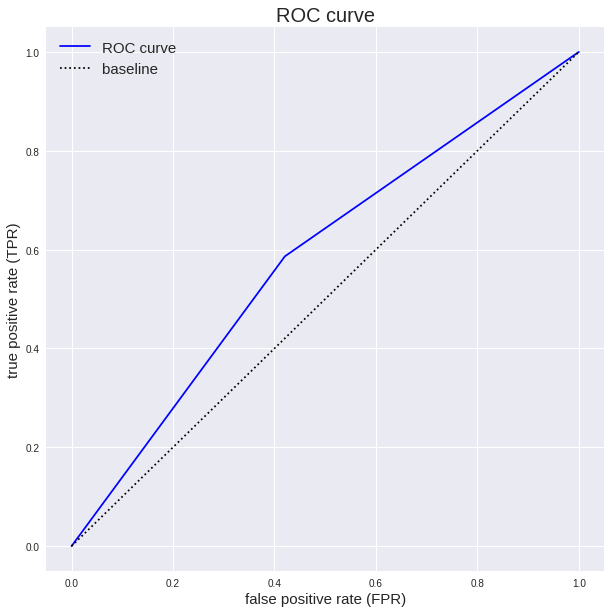

In [39]:
plotROC(fpr_test, tpr_test)

0.9999981861038201


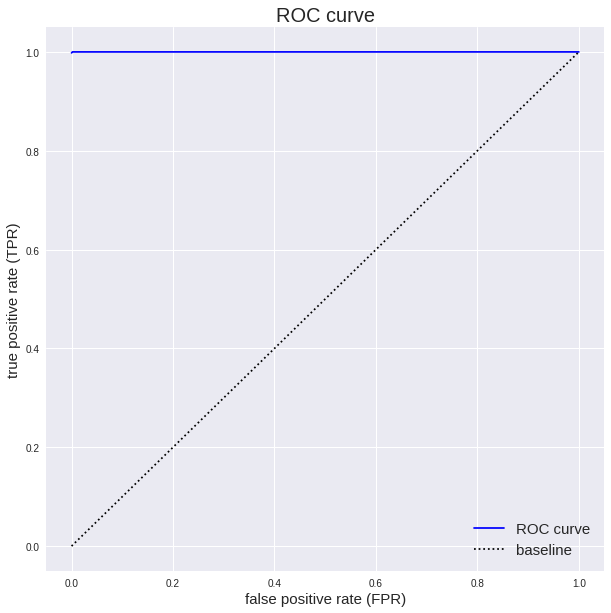

In [40]:
Y_train_prob = clf.predict_proba(X_train)

auc = sklearn.metrics.roc_auc_score(Y_train,Y_train_prob[:,1])
print(auc)

fpr_train, tpr_train, tresholds = sklearn.metrics.roc_curve(Y_train, Y_train_prob[:,1])

plotROC(fpr_train, tpr_train)

**What's wrong here?**

## 2.3 Regularization


In the code above, we have not limited the growth of our tree in any way. As a result, the tree has kept making splits untill every node had zero impurities. The result is a tree that is overfitted on the data.

For decision trees, the growth of the tree must be limited to avoid overfitting. This can be done in multiple ways. In the next section we will limited the tree growth by:

1. Limiting the maximum depth of the tree
2. Setting a minimum amount off samples required to allow another split of a tree stump

This introduces two hyperparameters: 

1. The maximum depth
2. The minimum amount of samples to split

We will use both techniques at the same time with fixed values for the hyperparameters. 

In a more advanced scenario, one could use both techniques together with different combinations of hyperparameters to obtain the global optimal set of hyperparameters. In section 4.3 we plot the results for different values of hyperparameters. Since this code requires some time to complete, the resulting figures are included in the notebook so you don't have to run the code again. 



In [54]:
  depth = 10
  split_amount = 300
  
  clf = tree.DecisionTreeClassifier(random_state=0, max_depth = depth, min_samples_leaf = split_amount)
  clf.fit(X_train, Y_train)
  Y_test_prob = clf.predict_proba(X_test)
  auc = sklearn.metrics.roc_auc_score(Y_test,Y_test_prob[:,1])
  print("AUC of this regularized tree: {0}".format(auc))

AUC of this regularized tree: 0.6475590132546231


## 2.4 Hyperparameter search

**NOTE:** Hyperparameter tuning involves the DEV (validation) set. 

### Hyper parameter search: limiting the maximum tree depth



In [19]:
depths = [1,3,5,8,10,20,30,40]

auc_results = []

for depth in depths:
  print("fitting with depth = {}...".format(depth))
  clf = tree.DecisionTreeClassifier(random_state=0, max_depth = depth)
  clf.fit(X_train, Y_train)
  Y_dev_prob = clf.predict_proba(X_dev)
  auc = sklearn.metrics.roc_auc_score(Y_dev,Y_dev_prob[:,1])
  auc_results.append(auc)

fitting with depth = 1...
fitting with depth = 3...
fitting with depth = 5...
fitting with depth = 8...
fitting with depth = 10...
fitting with depth = 20...
fitting with depth = 30...
fitting with depth = 40...


**Watch the result** [here](https://drive.google.com/open?id=19VYv95yLx9beSdoxyn5NenC7p2Uqmox1)



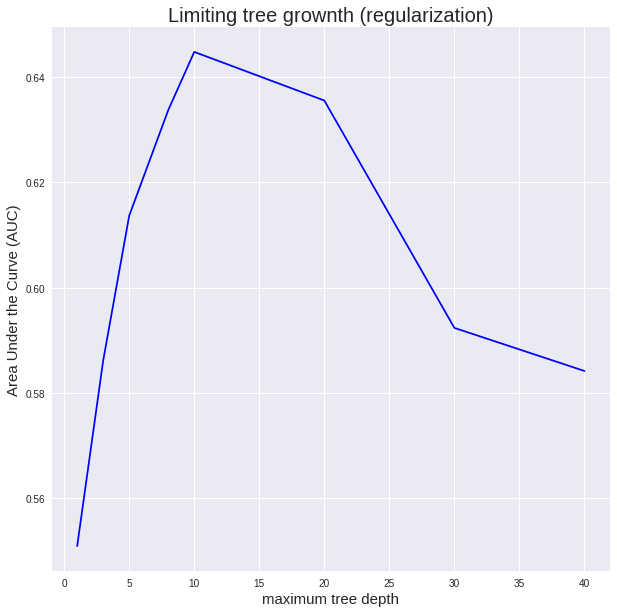

In [20]:
  fig = plt.figure(figsize = (10,10))
  plt.xlabel("maximum tree depth",fontsize = 15)
  plt.ylabel("Area Under the Curve (AUC)",fontsize = 15)
  plt.title("Limiting tree growth (regularization)",fontsize=20)
  plt.plot(depths, auc_results, "b")
  plt.show()

It appears that the best validation error is for a depth around 10. Let's evaluate the TEST error for this depth.

**Question:** How will the AUC versus tree depth look when evaluating on the **training set**?

In [23]:
clf = tree.DecisionTreeClassifier(random_state=0, max_depth = 10)
clf.fit(X_train, Y_train)

Y_test_prob = clf.predict_proba(X_test)

auc = sklearn.metrics.roc_auc_score(Y_test,Y_test_prob[:,1])

print("test AUC: {0}".format(auc))

test AUC: 0.6487320448694676


### Hyperparameter search: minimum amount of samples to split

In [21]:
split_amounts = [2,300,500,750,1500]

auc_results = []

for split_amount in split_amounts:
  print("fitting with minimum {} samples before splitting..".format(split_amount))
  clf = tree.DecisionTreeClassifier(random_state=0, min_samples_leaf = split_amount)
  clf.fit(X_train, Y_train)
  Y_dev_prob = clf.predict_proba(X_dev)
  auc = sklearn.metrics.roc_auc_score(Y_dev,Y_dev_prob[:,1])
  auc_results.append(auc)

fitting with minimum 2 samples before splitting..
fitting with minimum 300 samples before splitting..
fitting with minimum 500 samples before splitting..
fitting with minimum 750 samples before splitting..
fitting with minimum 1500 samples before splitting..


**Watch the result** [here](https://drive.google.com/open?id=1nZV9R8kGMq3_c_VEIWtObSh9yi4kUzDd)

**Exercise:** What is the best minimum amount of samples to split? Find the TEST error for this model.



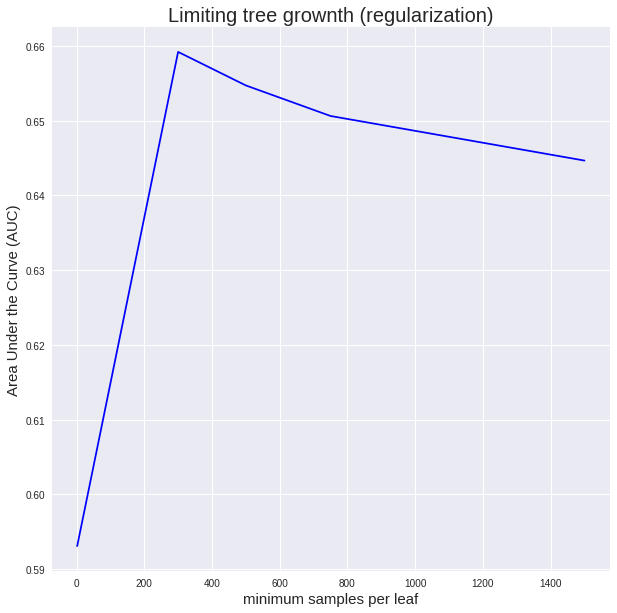

In [22]:
  fig = plt.figure(figsize = (10,10))
  plt.xlabel("minimum samples per leaf",fontsize = 15)
  plt.ylabel("Area Under the Curve (AUC)",fontsize = 15)
  plt.title("Limiting tree growth (regularization)",fontsize=20)
  plt.plot(split_amounts, auc_results,"b")
  plt.show()

# 3 Boosted tree

We will training a model of boosted decision stumps. The base classifier is a tree with depth = 1

In [0]:
from sklearn.ensemble import AdaBoostClassifier

In [0]:
base_classifier = tree.DecisionTreeClassifier(random_state=0, max_depth = 1)
adaboost_classifier = AdaBoostClassifier(base_classifier, 50)

In [17]:
adaboost_classifier.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [18]:
Y_test_prob = adaboost_classifier.predict_proba(X_test)

auc = sklearn.metrics.roc_auc_score(Y_test,Y_test_prob[:,1])

print("test AUC: {0}".format(auc))

AUC: 0.6532545941413622


We will leave the hyperparamter tuning of T as an exercise.